In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm


from utils.plots import visualize_vehicle_trajectories, plot_interactive_matrix, visualize_merge_pairs_grid, visualize_merge_chains_grid
from utils.loader import load_data_from_database
from utils.transformer import categorize_ids, find_merging_pairs, build_merge_chains

/Users/workflow/FHNW git/HS2025 git/Traffic-monitoring-Challenge/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Do you want to load data from the database? This may take a while.")
if input("Type 'y' to proceed: ").lower() == 'y':
    df = load_data_from_database()
    df = df.sort_values(['date_time', 'frame_id'])
else:
    df = pd.read_csv("raw_traffic_data.csv", parse_dates=['date_time'])
    df = df.sort_values(['date_time', 'frame_id'])

Do you want to load data from the database? This may take a while.


In [3]:
df['session_id'] = (
    (df['frame_id'].diff() < 0)
).cumsum()

In [4]:
df.groupby('session_id').agg('size')

session_id
0       28090
1       15936
2     8238814
3       33537
4        7082
5       10582
6        8504
7       17186
8       30834
9        5361
10      26281
11      17976
12      12914
13      26303
14     489001
15      17536
dtype: int64

In [23]:
# 1. Select one stable session and sort
session_id_to_analyze = 2
session_df = df[df['session_id'] == session_id_to_analyze].sort_values(['vehicle_id', 'date_time'])

# Filter vehicle_id with less than 40 records
vehicle_counts = session_df['vehicle_id'].value_counts()
valid_vehicles = vehicle_counts[vehicle_counts >= 50].index
session_df = session_df[session_df['vehicle_id'].isin(valid_vehicles)]


In [24]:
final_summary = categorize_ids(session_df)
final_summary.groupby('category').agg('size')

category
Flickering          159
Partial           11525
Perfect           28039
RelayCandidate     6212
Static            14270
dtype: int64

In [25]:
fig = plot_interactive_matrix(final_summary, max_points_per_category=500)
fig.show()


In [26]:
filter_category = 'Perfect'
filtered_final_summary = final_summary[(final_summary['category'] == filter_category)]
filtered_final_summary

,session_id,vehicle_id,y_start,y_end,w_mean,w_std,h_mean,h_std,frames_count,t_start,t_end,x_mean,x_std,path_completeness,w_cv,h_cv,movement_efficiency,category
0,2,4,263,0,39.704348,4.643377,56.808696,17.317416,115,2025-11-29 18:04:24.233579,2025-11-29 18:04:31.759723,139.086957,2.019924,0.906897,0.116949,0.304837,0.007886,Perfect
2,2,27,271,0,60.679012,10.346575,92.067901,73.442767,162,2025-11-29 18:05:45.831297,2025-11-29 18:05:56.357031,136.135802,3.893786,0.934483,0.170513,0.797702,0.005768,Perfect
6,2,65,264,0,67.163934,12.724229,150.016393,63.456413,61,2025-11-29 18:06:43.875798,2025-11-29 18:06:47.774104,143.344262,7.307269,0.910345,0.189450,0.422997,0.014924,Perfect
7,2,124,0,265,75.961039,22.673565,74.558442,25.377929,77,2025-11-29 18:08:50.782444,2025-11-29 18:08:55.893554,21.311688,16.679849,0.913793,0.298489,0.340376,0.011867,Perfect
8,2,189,271,0,39.709677,4.913638,67.677419,18.994196,62,2025-11-29 18:13:32.027510,2025-11-29 18:13:36.077078,136.338710,1.649079,0.934483,0.123739,0.280658,0.015072,Perfect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60199,2,404131,0,262,62.142857,15.932193,88.559524,26.183942,84,2025-12-18 11:01:11.218138,2025-12-18 11:01:14.360564,22.488095,17.468384,0.903448,0.256380,0.295665,0.010755,Perfect
60200,2,404132,254,0,58.660000,9.560250,85.870000,35.789693,100,2025-12-18 11:01:49.007362,2025-12-18 11:01:52.920998,133.790000,3.814632,0.875862,0.162977,0.416789,0.008759,Perfect
60201,2,404133,264,0,47.870588,8.214082,59.200000,12.261826,85,2025-12-18 11:01:51.786257,2025-12-18 11:01:55.054317,142.188235,6.970165,0.910345,0.171589,0.207125,0.010710,Perfect
60202,2,404135,272,0,58.540323,10.001950,82.967742,29.568148,124,2025-12-18 11:01:57.507097,2025-12-18 11:02:02.401481,136.766129,4.540887,0.937931,0.170856,0.356381,0.007564,Perfect


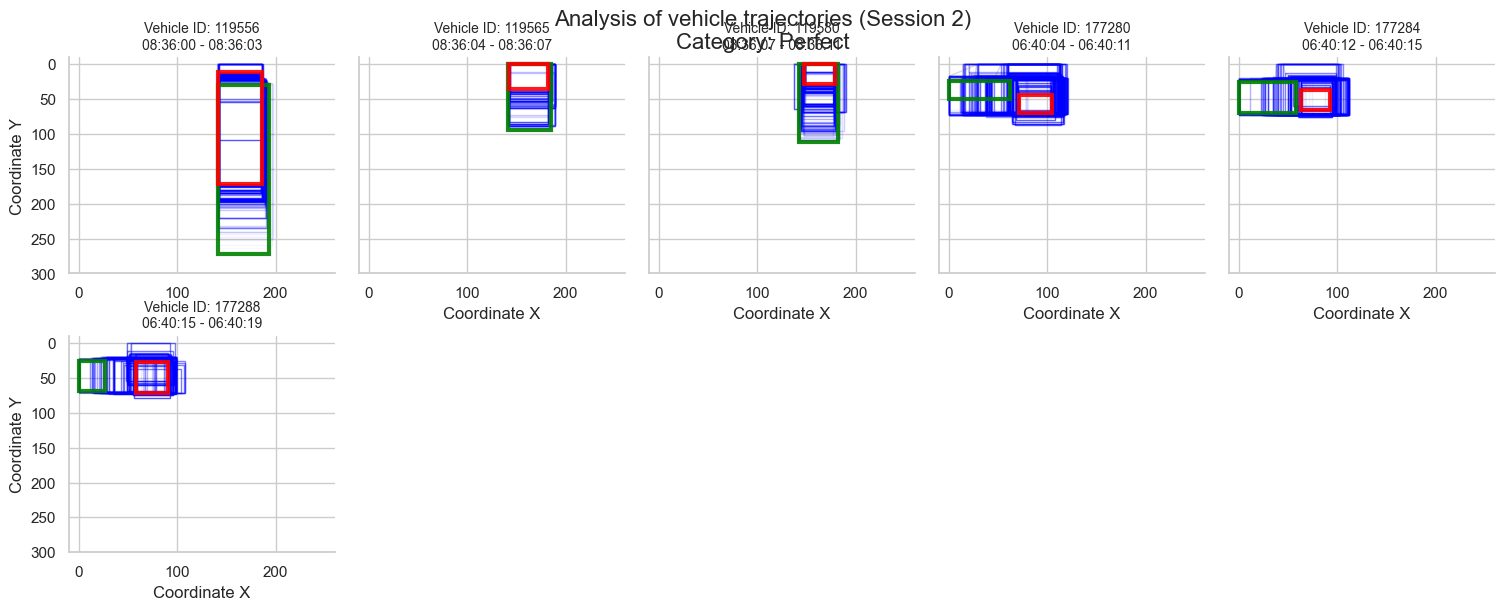

In [41]:
ids_to_plot = filtered_final_summary['vehicle_id']
ids_to_plot = [177280, 177284, 177288, 119556, 119565, 119580]
plot_data = session_df[session_df['vehicle_id'].isin(ids_to_plot)]
visualize_vehicle_trajectories(plot_data, session_id=session_id_to_analyze, max_vehicles=25, min_records=20, category=filter_category)

In [43]:
plot_data.groupby('vehicle_id').agg('size')

vehicle_id
119556     87
119565     57
119580    112
177280    169
177284     90
177288     87
dtype: int64

In [28]:

merge_results = find_merging_pairs(final_summary, category_filter=['RelayCandidate', 'Partial', 'Static'])
print(f"Found pairs for merging: {len(merge_results)}")
merge_results

Search for pairs for merging: 100%|██████████| 32007/32007 [00:00<00:00, 672600.82ID/s]

Found pairs for merging: 570


,old_id,new_id,gap_sec,y_dist,size_diff_pct,old_x_start,old_y_start,old_x_end,old_y_end,new_x_start,new_y_start,new_x_end,new_y_end,old_t_start,old_t_end,new_t_start,new_t_end
0,1253,1258,0.05,0,0.6,46.3,0,46.3,0,63.8,0,63.8,246,2025-11-29 19:02:51.618049,2025-11-29 19:02:55.123874,2025-11-29 19:02:55.175476,2025-11-29 19:03:03.204256
1,4947,4949,0.19,1,11.1,138.7,266,138.7,267,120.3,266,120.3,271,2025-11-29 22:25:22.667752,2025-11-29 22:25:24.461967,2025-11-29 22:25:24.648511,2025-11-29 22:25:26.815447
2,5145,5151,0.57,5,18.2,143.8,23,143.8,20,132.0,15,132.0,0,2025-11-29 22:34:14.794105,2025-11-29 22:34:18.943756,2025-11-29 22:34:19.512914,2025-11-29 22:34:22.238280
3,6837,6844,0.15,9,2.2,84.8,28,84.8,16,92.0,25,92.0,15,2025-11-30 02:45:47.552960,2025-11-30 02:45:52.450813,2025-11-30 02:45:52.601213,2025-11-30 02:45:57.234605
4,6909,6925,1.32,28,16.6,99.0,26,99.0,15,106.4,43,106.4,18,2025-11-30 03:46:15.986529,2025-11-30 03:46:19.979676,2025-11-30 03:46:21.304184,2025-11-30 03:46:24.296220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,401968,401976,0.86,39,12.9,47.6,0,47.6,68,53.8,107,53.8,215,2025-12-18 08:16:20.093324,2025-12-18 08:16:22.674609,2025-12-18 08:16:23.532642,2025-12-18 08:16:26.484945
566,402991,402993,0.30,5,1.8,0.0,0,0.0,48,0.0,53,0.0,113,2025-12-18 09:25:19.343946,2025-12-18 09:25:21.512641,2025-12-18 09:25:21.814327,2025-12-18 09:25:25.263767
567,403160,403163,0.07,22,15.0,130.5,266,130.5,66,134.4,44,134.4,0,2025-12-18 09:35:14.508610,2025-12-18 09:35:16.483024,2025-12-18 09:35:16.558023,2025-12-18 09:35:18.586401
568,403461,403470,1.15,6,5.8,135.7,277,135.7,152,138.0,146,138.0,90,2025-12-18 10:06:47.850284,2025-12-18 10:06:53.009489,2025-12-18 10:06:54.156286,2025-12-18 10:06:57.430744


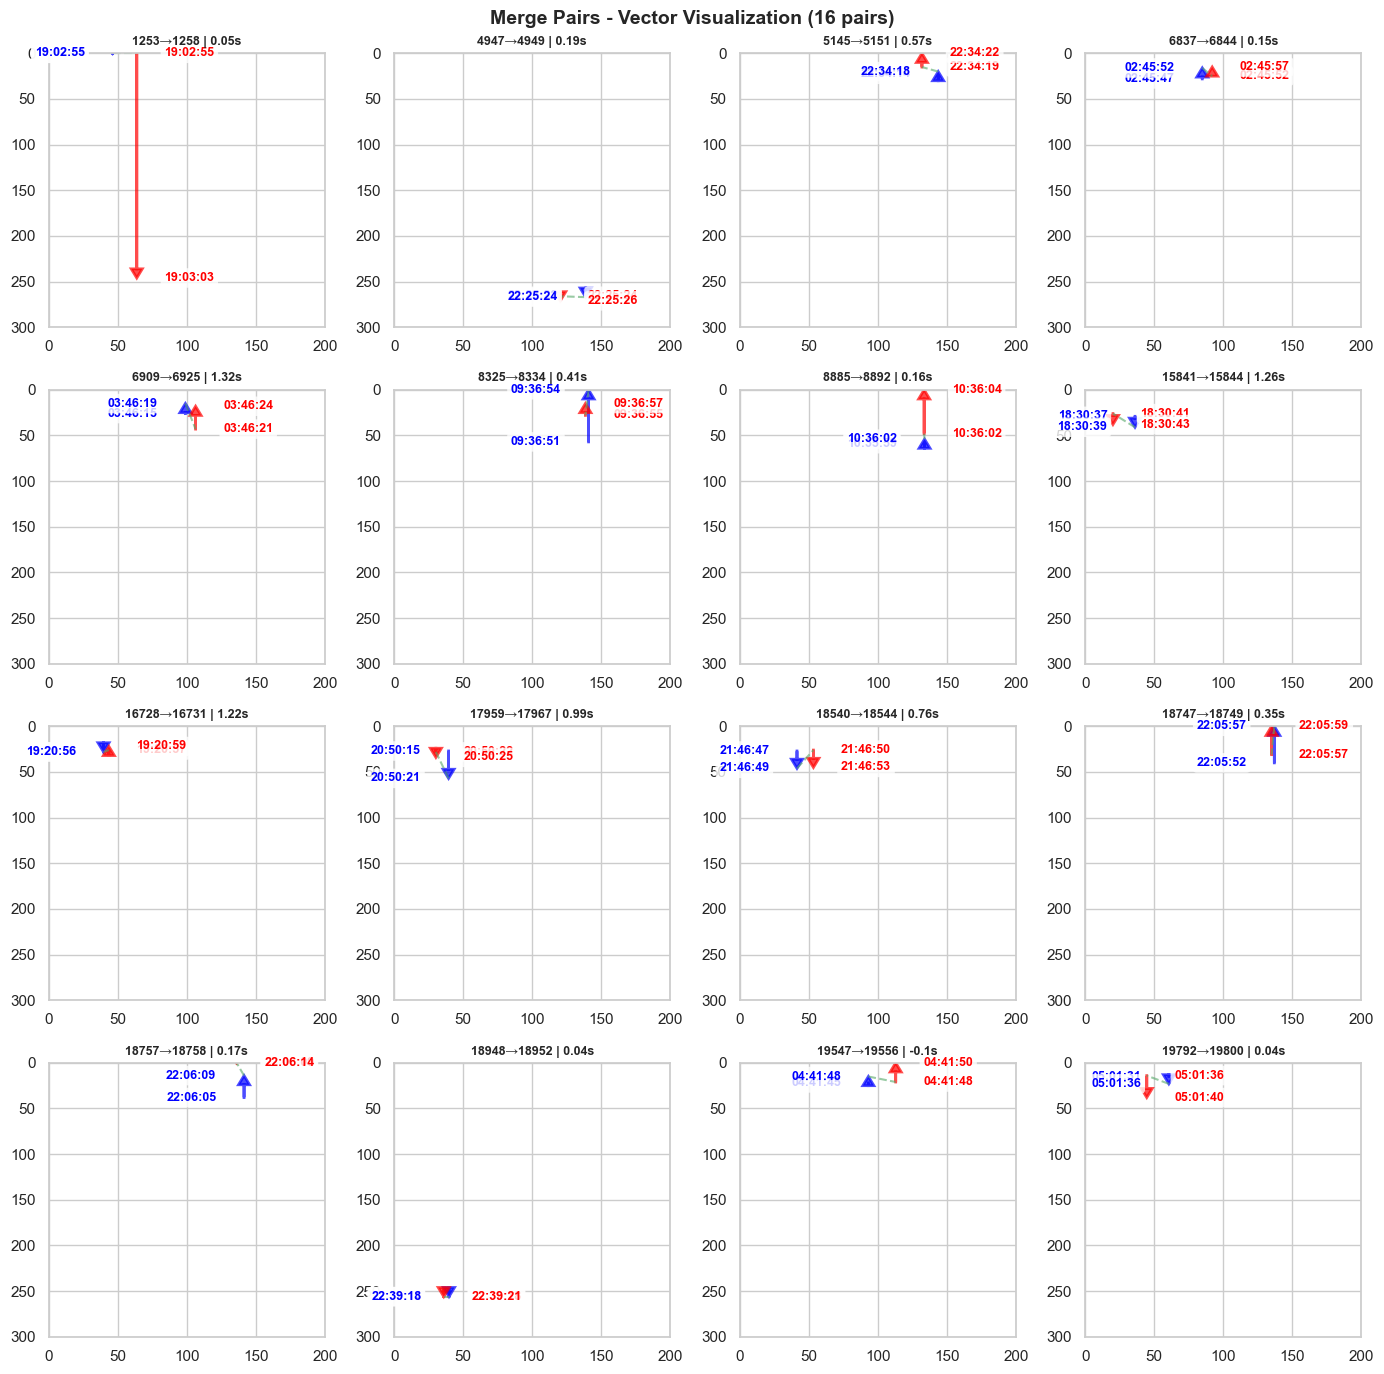

In [30]:
# Visualize
fig = visualize_merge_pairs_grid(merge_results, n_pairs=16, cols=4)
plt.show()


In [31]:
chains = build_merge_chains(merge_results)
print(f"Found {len(chains)} chains")
print(f"Longest chain has {max(len(c) for c in chains) if chains else 0} IDs")
print("\nFirst 10 chains (sorted by time):")
for i, chain in enumerate(chains[:10]):
    # Get start time for display
    first_id = chain[0]
    first_row = merge_results[merge_results['old_id'] == first_id].iloc[0] if len(merge_results[merge_results['old_id'] == first_id]) > 0 else None
    time_str = first_row['old_t_start'].strftime('%H:%M:%S') if first_row is not None else "??:??:??"
    print(f"{i+1}. [{time_str}] {' → '.join(map(str, chain))}")


Found 560 chains
Longest chain has 3 IDs

First 10 chains (sorted by time):
1. [19:02:51] 1253 → 1258
2. [22:25:22] 4947 → 4949
3. [22:34:14] 5145 → 5151
4. [02:45:47] 6837 → 6844
5. [03:46:15] 6909 → 6925
6. [09:36:51] 8325 → 8334
7. [10:35:59] 8885 → 8892
8. [18:30:37] 15841 → 15844
9. [19:20:53] 16728 → 16731
10. [20:50:15] 17959 → 17967


In [32]:
long_chains = [chain for chain in chains if len(chain) > 2]
print(f"Chains with more than 5 IDs: {len(long_chains)}")
long_chains 

Chains with more than 5 IDs: 10


[[46499, 46502, 46508],
 [119556, 119565, 119580],
 [125056, 125063, 125072],
 [127687, 127692, 127693],
 [127868, 127878, 127882],
 [140654, 140665, 140677],
 [177280, 177284, 177288],
 [190132, 190137, 190144],
 [200433, 200435, 200443],
 [384968, 384970, 384975]]

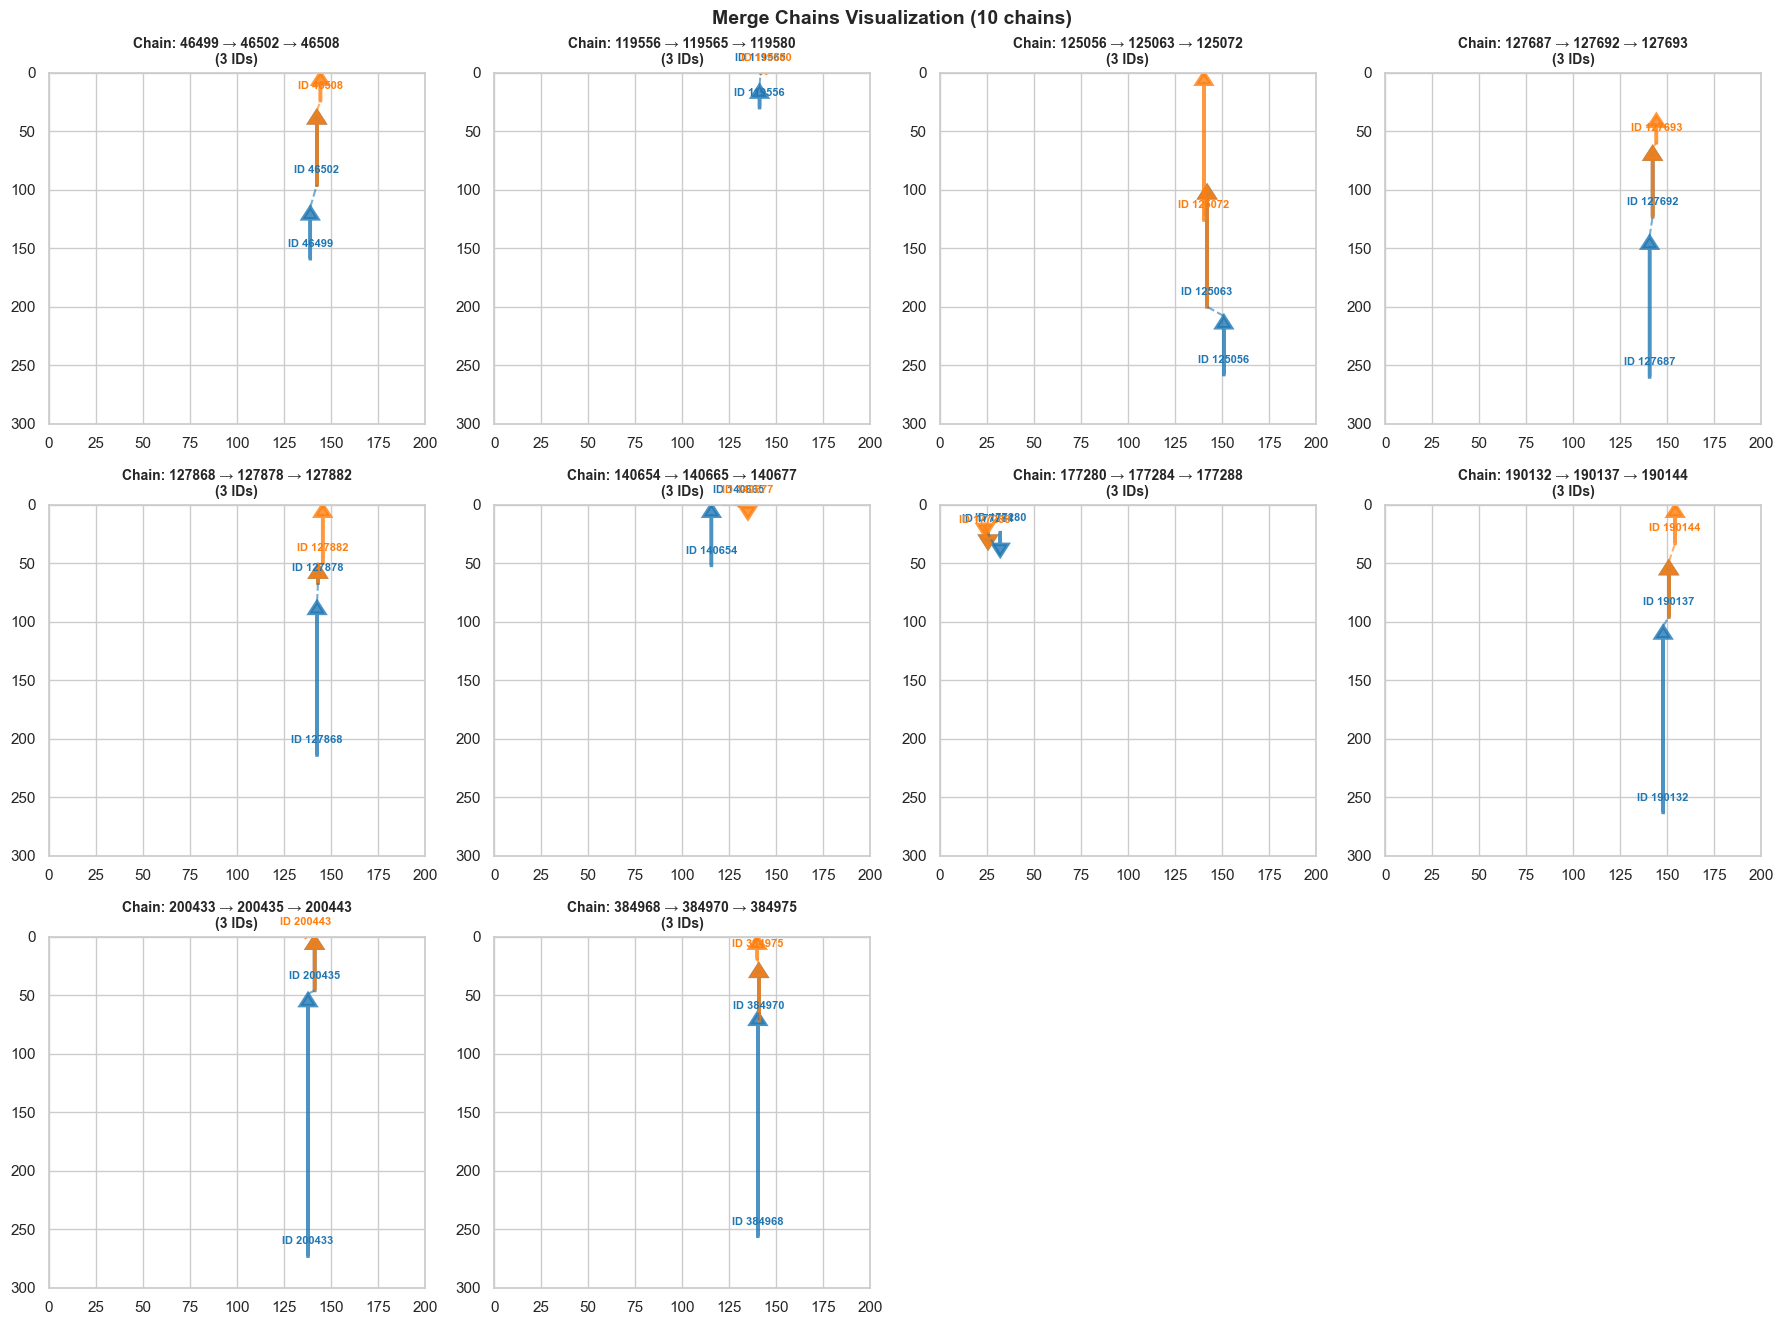

In [33]:
# Visualize chains
fig = visualize_merge_chains_grid(merge_results, long_chains, n_chains=16, cols=4)
plt.show()


In [34]:
# df['year'] = df['date_time'].dt.year
# df['month'] = df['date_time'].dt.month
# df['day'] = df['date_time'].dt.day
# df['hour'] = df['date_time'].dt.hour
# df['unique_vehicle_id'] = round(df['vehicle_id'] + df['year']/10000 + df['month']/1000000 + df['day']/100000000 + df['hour']/10000000000, 10)
# df['unique_frame_id'] = round(df['vehicle_id'] + df['year']/10000 + df['month']/1000000 + df['day']/100000000 + df['hour']/10000000000, 10)
# df.head()

In [35]:
# df['size'] = df['width'] * df['heigth']
# df.head()

In [36]:
# min_max_df = df.groupby('unique_vehicle_id')[['size', 'y']].agg(['max', 'min']).sort_index()

In [37]:
# min_max_df['way_size'] = min_max_df['y']['max'] - min_max_df['y']['min']
# min_max_df.columns = ['size_max', 'size_min', 'y_max', 'y_min', 'way_size']
# min_max_df.head()

In [38]:
# min_max_df['full_way'] = min_max_df['way_size'] > 240

In [39]:
# min_max_df['day'] = min_max_df.index.map(lambda x: True if 6 <= int((x* 10000000000)%100) < 18 else False)

In [40]:
# min_max_df